# Comparisons to full Hemibrain figures
First Figure:
This figure was created by using a basic joint marginal function written by Kunin et al. The steps for this were:
1. Pull in modularity data for the inputs and the whole brain
2. Define the base modularity (0.0) and the suffixes for each modularity group
3. Use the modularity merge function to compare where each neuron id ends up in each modularity data
4. Each neuron is tagged with the correct suffix and the plots are created based on module breakdown 

Second Figure: 
1. Filter both dataframes for the overlapping neurons (exist in both datasets)
    
    a. We are comparing the coarse modules of one connectome to all the resolutions of the other connectome

2. Adjust jaccard similarity functions to be able to pull from two data frames to create the zero and new set. These functions were written and tested in the jaccardsim_analysis.ipynb file
3. Analyze the inputs and WB data against eachother

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import networkx as nx
import collections
from scipy import sparse as sp
from scipy.stats import rankdata

import itertools
from itertools import combinations, combinations_with_replacement, cycle
from functools import reduce

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import bokeh.palettes

# darkening colors for readability
import matplotlib.colors as mcolors
import colorsys

import colorcet as cc

import bokeh
from bokeh.io import output_notebook, output_file, show, save, export_svg
from bokeh.plotting import figure
from bokeh.models import (Rect, MultiLine, Circle, Span, Label,
                          GraphRenderer, StaticLayoutProvider,
                          NodesAndLinkedEdges,
                          HoverTool, TapTool, ColumnDataSource,
                          LinearColorMapper, LogColorMapper, CategoricalColorMapper,
                          CategoricalMarkerMapper,
                          BoxSelectTool,
                          ColorBar, BasicTicker, BoxZoomTool, FactorRange,
                          Range1d)
from bokeh.models import CategoricalTicker, FixedTicker, BoxAnnotation
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead, LabelSet
import bokeh.palettes
from bokeh.transform import transform, factor_cmap, linear_cmap, log_cmap
from bokeh.layouts import row, column, gridplot
from bokeh.resources import INLINE
output_notebook(INLINE)

# Set 'pdf.fonttype' to 42 to keep the text editable after exporting to pdf
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"

This joint marginal function was copied from Alexander Kunin's code and finds the joint fraction count and the fraction for each dataset. The fraction for each dataset is used for plotting. Two datasets with 0.0 resolution and bodyids are required to produce this figure.

In [3]:
def joint_marginal(df, c1, c2, include_fraction=False):
    """Given a dataframe and two columns, return a dataframe with the joint and marginal counts."""
    j = df.value_counts([c1, c2])
    j.name = "joint_count"
    j = j.reset_index()

    m1 = df.value_counts(c1)
    m1.name = f"{c1}_count"
    j = j.merge(m1, left_on=c1, right_index=True)

    m2 = df.value_counts(c2)
    m2.name = f"{c2}_count"
    j = j.merge(m2, left_on=c2, right_index=True)

    if include_fraction:
        j["joint_fraction"] = j["joint_count"] / j["joint_count"].sum()
        j[f"{c1}_fraction"] = j["joint_count"] / j[f"{c1}_count"]
        j[f"{c2}_fraction"] = j["joint_count"] / j[f"{c2}_count"]
    return j

hemibrain_version = "v1.2.1"
#log_msg("Hemibrain data set being used:", hemibrain_version)

# Load the data
wbs = pd.read_csv('/Users/pranjalsrivastava/Work/RA work/oviIN-inputs/preprocessed_nodes.csv', index_col=0)
mod = pd.read_csv('modularity_runs/0.0/0-0_98765.txt', header=None, sep=' ', names=['id', '0.0'])

## Color palette
This was based off of the bokeh palette 'Light' and darkened using a function from stackoverflow. The purple color was pulled from bokeh as well (D3['Category10'])

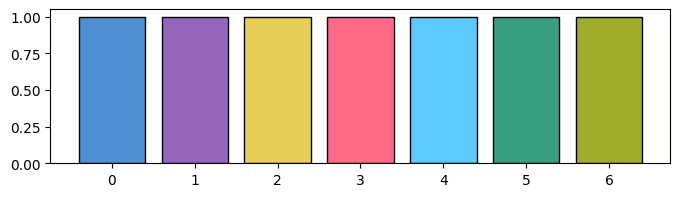

In [10]:
colors = ['#4e90d3', '#9467bd', '#e7cf57', '#ff6a88', '#5cc9ff', '#3a9f82', '#9fad2b']
colors

# plot darker colors
plt.figure(figsize=(8,2))
for i, color in enumerate(colors):
    plt.bar(i, 1, color=color, edgecolor='black')

In [11]:
mod['0.0']

0       1
1       2
2       3
3       3
4       4
       ..
1827    2
1828    6
1829    5
1830    5
1831    5
Name: 0.0, Length: 1832, dtype: int64

## Joint Marginals

The joint marginal counts are calculated between the 0.0 resolution of the oviINr input connectome against the 0.0 resolution of the hemibrain modularity. The hemibrain modularity was run by Alexander Kunin and used the same modularity algorithm. 

In [12]:
# Copied from Prof G's code on github (https://github.com/Gutierrez-lab/oviIN-analyses-gabrielle/blob/main/modular_sandbox.ipynb)
def modularity_merge(df1,df2,suf1,suf2):
    """Given two modularity dataframes, merge them along shared body IDs. Pass in suffixes for the columns as strings."""
    merged_mod_df = df1.merge(df2, left_on='id', right_on='id', suffixes=[suf1, suf2])
    #merged_mod_df = df1.merge(df2, left_on='id', right_on='id', suffixes=['_oviHB', '_wholeHB'])
    return merged_mod_df

# Defining base res and suffixes
res = '0.0'
df1_suf = '_oviHB'
df2_suf = '_wholeHB'

# Using merge function from code cell above
mod_merge_df = modularity_merge(mod,wbs[[res]],df1_suf,df2_suf)
mod_merge_df
chi1 = res + df1_suf
chi2 = res + df2_suf

In [ ]:
#create dictionary
color_dict = dict(zip(mod_merge_df[res + df1_suf].unique(), colors))
color_dict

# create joint marginal dataframe
jm = joint_marginal(mod_merge_df, chi1, chi2, include_fraction=True)

# map colors into the dataframe
jm['color']=jm['0.0_oviHB'].map(color_dict)

# sort the clusters on the y axis to get a more "diagonal" plot
yrange = jm.sort_values([f"{chi2}_fraction"], ascending=False).groupby(chi2).agg({chi1: "first", f"{chi2}_fraction": "first", "joint_count": "first"}).sort_values([chi1, "joint_count"], ascending=[True, False]).index

# make a bokeh figure
f = figure(title=f"Module at chi2 = {chi2} vs. module at chi1 = {chi1}",
x_range=FactorRange(factors=[str(i + 1) for i in range(jm[chi1].max())]),
y_range=FactorRange(factors=[str(y) for y in yrange]),
width=600, height=700)
jm["x"] = jm[chi1].apply(str)  # bokeh factor range has to have strings, so we have to convert these
jm["y"] = jm[chi2].apply(str)

f.rect(x="x", y="y", width=f"{chi1}_fraction", height=f"{chi2}_fraction", source=jm, fill_color='color', line_color='color')
f.add_tools(HoverTool(tooltips={"Neurons": "@joint_count (@joint_fraction{%%} of Hemibrain)",
                                f"Fraction of {chi2}": f"@{{{chi2}_fraction}}{{2.%%}}",
                                f"Fraction of {chi1}": f"@{{{chi1}_fraction}}{{2.%%}}"}))
f.xaxis.axis_label = 'Module in ' +chi1
f.yaxis.axis_label = 'Module in ' +chi2
show(f)

In [19]:
f.output_backend = "svg"

export_svg(f, filename="figures/joint_marginal.svg")

['figures/joint_marginal.svg']

## Jaccard Similarity between oviIN coarse modules and WB

In [20]:
# Define BodyIds from the inputs
ids = mod['id']

# Filter the wb data to only include the bodyIds from the inputs
wb = wbs[wbs.index.isin(ids)]

# Filter the input data to only include the overlapping bodyIds
df_in_filtered = mod[mod.index.isin(wb.index.values)]

In [21]:
# create a function that takes in two lists of id numbers and returns the jaccard sim of the two lists
def calculate_difference(list1, list2):
    set1 = set(list1)
    set2 = set(list2)

    unique_1 = set1-set2
    unique_2 = set2-set1

    # Union of set1 and set 2
    union_1_2 = set1 | set2
    common = set1.intersection(set2)

    # calculate Jaccard similarity
    jaccard_sim = len(common) / len(union_1_2)

    return unique_1, unique_2, common, jaccard_sim

# function that takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare
def get_body_ids(df, coarse_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi value at which to compare. 
    It returns a dictionary of body IDs for each cluster number at the resolution and a dictionary of body IDs for each cluster 
    number at the base resolution."""

    # Gets cluster numbers for resolution
    chi_values = [chi]
    cluster_all = np.zeros((len(coarse_modules),len(chi_values), 800))
    for i, x in enumerate(coarse_modules):
        df_test = df[df['0.0']==x]
        for f, y in enumerate(chi_values):
            cluster = df_test[y].unique()
            cluster_all[i,f, :len(cluster)] = cluster

    # move everything to a dictionary
    dict = {}
    for i, x in enumerate(coarse_modules):
        dict[coarse_modules[i]] = cluster_all[i,0]
    
    # Remove the zeros from the array
    for key, value in dict.items():
        dict[key] = value[value != 0]
        dict[key] = np.array(value, dtype='int64')
    
    # Get bodyIDs for each cluster number in the resolution
    dict_new = dict.fromkeys(coarse_modules, [])
    for key, value in dict.items():
        body_ids = []
        for i, x in enumerate(value):
            body_ids.extend(df[df[chi]==x].index.tolist())
        dict_new[key] = body_ids

    return dict_new

# Function returns the zero set of the dataframe given
def get_zero_set(df, zero_modules):
    # Need bodyIds at zero resolution for each cluster number
    # create an empty dict using modules list given (zero_modules) as keys and empty lists as values
    dict_zero= dict.fromkeys(zero_modules, [])
    for key, value in dict_zero.items():
        dict_zero[key] = df[df['0.0']==key].index.tolist()
    return dict_zero
    
# Function that takes in partition dataframe, the modules at the base resolution, and the chi value at which to compare
def main_jaccard(df_zero, df, zero_modules, reg_modules, chi):
    """ This function takes in a partition dataframe, the modules at the base resolution, and the chi 
    value at which to compare. It returns a dataframe of the jaccard similarities between the resolutions at each cluster"""

    # Get the body IDs for each cluster number at the resolution and the base resolution
    dict_new = get_body_ids(df, reg_modules, chi)
    dict_zero = get_zero_set(df_zero, zero_modules)

    # Create a dictionary to store the jaccard similarities
    jaccard_dict = {}
    for key, value in dict_new.items():
        jaccard_dict[key] = []
        unique_1, unique_2, common, jaccard_sim = calculate_difference(dict_new[key], dict_zero[key])
        jaccard_dict[key].append(jaccard_sim)
    
    # Create a dataframe to store the jaccard similarities
    df_jaccard = pd.DataFrame(jaccard_dict)
    df_jaccard.index = np.arange(1, len(df_jaccard)+1)
    
    return df_jaccard

# Main function for the full process of jaccard similarity
def run_jaccard(chi_vals, zero_mods, coarse_modules, df_zero, df_change, title, x_label):
    """ This function takes in a list of chi values, the modules at the base resolution, and the chi value at which to compare. 
    It returns a dataframe of the jaccard similarities between the resolutions at each cluster"""

    # Create a dataframe to store the jaccard similarities
    df_jaccard = pd.DataFrame(index=np.arange(1, len(chi_vals)+1), columns=coarse_modules)

    # Loop through the chi values and calculate the jaccard similarities
    for i, chi in enumerate(chi_vals):
        df_jaccard.loc[i+1] = main_jaccard(df_zero, df_change, zero_mods, coarse_modules, chi).values
    
    # Add in the mean similarity over all chi values
    df_jaccard['mean'] = df_jaccard.mean(axis=1)

    # Transpose and rename columns to match the chi values
    df_jaccard = df_jaccard.T
    df_jaccard.columns = chi_vals

    return df_jaccard

In [ ]:
# Running jaccard similarity
coarse_modules = [1, 2, 3, 4, 5, 6, 7] # change to cluster number in dataset
zero_mods = [1, 2, 3, 4, 5, 6, 7] # change to cluster number in dataset
chi_vals = ['0.0', '0.05', '0.1','0.25', '0.5'] # change to chi values in dataset
jaccard_dictr = run_jaccard(chi_vals, zero_mods, coarse_modules, df_in_filtered, wb, title='Jaccard Sim of Input R clusters vs. changing WB res', x_label='Chi Value for WB')

fig, ax  = plt.subplots()
for i in range(0, len(zero_mods)):
    ax.plot(jaccard_dictr.columns, jaccard_dictr.iloc[i], linestyle= '-',label='Module ' + str(i+1), color=colors[i], marker='o')

# Plot mean
ax.plot(jaccard_dictr.columns, jaccard_dictr.iloc[len(zero_mods)], linestyle = "--", label='Mean', color='grey')

ax.set_ylim(0, 1.0)
ax.legend()
# larger tick labels
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Jaccard Similarity', fontsize=14)
ax.set_xlabel('Chi Value of WB', fontsize=14)
ax.set_title("Input R clusters vs. changing WB res")
#fig.savefig('manuscript_figs/Figure5C_jaccardsim.pdf', format='pdf')


## Jaccard-Similarity Study (pairwise)

We consider the Jaccard Similarity between the Full-brain and the modularity run on the traced uncropped inputs of oviIn with 0.0 resolution. This Similarity analysis is based on the pairs of neurons common to both clusterings

In [46]:
import itertools

def cluster_similarity(cluster_1, cluster_2, mode='both', node_filter=None):
    """
    Calculate the similarity between two clusterings using either the Jaccard index, Rand index, or both.

    Parameters:
    cluster_1 (dict): A dictionary representing the first clustering where keys are nodes and values are cluster labels.
    cluster_2 (dict): A dictionary representing the second clustering where keys are nodes and values are cluster labels.
    mode (str): The similarity measure to use ('jaccard', 'rand', or 'both'). Defaults to 'both'.
    node_filter (set, optional): A set of nodes to include in the comparison. If None, all nodes are included.

    Returns:
    float or tuple: The Jaccard index, Rand index, or both depending on the selected mode.
    
    Raises:
    AssertionError: If the mode is not one of 'jaccard', 'rand', or 'both', or if the clusterings do not have the same nodes.
    """
    # Ensure the mode is one of the valid options
    assert mode in ['jaccard', 'rand', 'both'], "Not a valid mode, please choose 'jaccard', 'rand' or 'both'"
    # Ensure both clusterings have the same set of nodes
    assert set(cluster_1.keys()) == set(cluster_2.keys())
    nodes = set(cluster_1.keys())
    
    # Apply node filter if provided
    if node_filter is not None:
        filter_set = set(node_filter)
        nodes = nodes.intersection(filter_set)
    
    # Initialize counters for pair counts
    f_0_0 = 0  # pair in different clusters in both clusterings
    f_0_1 = 0  # pair in different clusters in cluster_1 and same in cluster_2
    f_1_0 = 0  # pair in same cluster in cluster_1 and different in cluster_2
    f_1_1 = 0  # pair in same clusters in both clusterings

    # Count the number of pairs in each category
    for n1, n2 in itertools.combinations(nodes, 2):
        if cluster_1[n1] == cluster_1[n2] and cluster_2[n1] == cluster_2[n2]:
            f_1_1 += 1
        elif cluster_1[n1] == cluster_1[n2] and cluster_2[n1] != cluster_2[n2]:
            f_1_0 += 1
        elif cluster_1[n1] != cluster_1[n2] and cluster_2[n1] == cluster_2[n2]:
            f_0_1 += 1
        else:
            f_0_0 += 1
    # Calculate and return the similarity measure(s)
    if mode == 'jaccard':
        return f_1_1 / (f_1_1 + f_0_1 + f_1_0)
    if mode == 'rand':
        return (f_1_1 + f_0_0) / (f_1_1 + f_1_0 + f_0_1 + f_0_0)
    
    return f_1_1 / (f_1_1 + f_0_1 + f_1_0), (f_1_1 + f_0_0) / (f_1_1 + f_1_0 + f_0_1 + f_0_0)


We create the partition dictionaries for both the clusterings

In [47]:
wbs.reset_index(inplace=True)

In [48]:
resolutions = ['0.0', '0.05', '0.1','0.25', '0.5', '0.75', '1.0']
oviIn_input_clustering = {}
wb_clusterings = {res: {} for res in resolutions}

In [49]:
for i, row in mod.iterrows():
    oviIn_input_clustering[int(row['id'])] = row['0.0']

In [50]:
for i, row in wbs.iterrows():
    # print(i, row)
    if int(row['id']) in oviIn_input_clustering:
        for res in resolutions:
            wb_clusterings[res][int(row['id'])] = row[res]

We evaluate the Jaccard index and RAND similarity index with the clustering of the whole brain at different resolutions

In [52]:
jac_indices = {}
rand_scores = {}

for res in resolutions:
    jaccard_index, rand_score = cluster_similarity(oviIn_input_clustering, wb_clusterings[res])
    jac_indices[res] = jaccard_index
    rand_scores[res] = rand_score

In [ ]:

import matplotlib.pyplot as plt

plt.style.use('default')

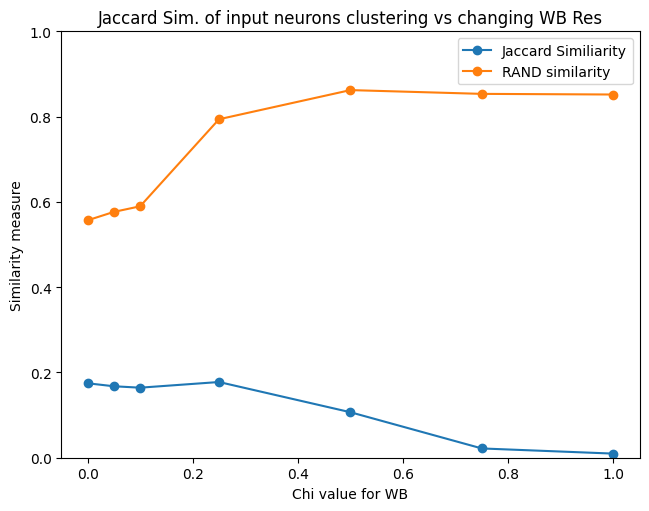

In [53]:
plt.plot([float(res) for res in resolutions], [jac_indices[res] for res in resolutions], marker='o', label = 'Jaccard Similiarity')
plt.plot([float(res) for res in resolutions], [rand_scores[res] for res in resolutions], marker='o', label = 'RAND similarity')
plt.legend(loc='upper right')
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('Chi value for WB')
plt.ylabel('Similarity measure')
plt.title('Jaccard Sim. of input neurons clustering vs changing WB Res')
plt.show()

We observe a clear downward trend in the Jaccard similarity while the RAND similarity has an upward trend

## Cluster-wise breakdown


In [55]:
cluster_nodes = {}
for i in range(1, 8):
    cluster_nodes[i] = [node for node in oviIn_input_clustering.keys() if oviIn_input_clustering[node] == i]

In [56]:
cluster_jac_similarities = {}
cluster_rand_similarities = {}

In [57]:
clusterwise_jac_similarities = {}
clusterwise_rand_similarities = {}

In [58]:
for i in range(1, 8):
    cluster_jac_similarities[i] = {}
    cluster_rand_similarities[i] = {}
    for res in resolutions:
        cluster_jac_similarities[i][res], cluster_rand_similarities[i][res] = cluster_similarity(oviIn_input_clustering, wb_clusterings[res], node_filter=cluster_nodes[i])
        
    

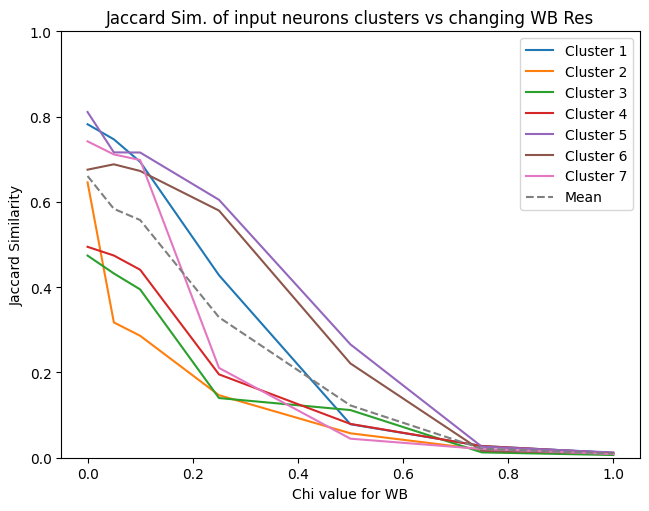

In [59]:
for i in range(1, 8):
    plt.plot([float(res) for res in resolutions],
             [cluster_jac_similarities[i][res] for res in resolutions],
             label = f'Cluster {i}')
plt.plot([float(res) for res in resolutions],
         [np.mean([cluster_jac_similarities[i][res] for i in range(1,8)]) for res in resolutions], label = 'Mean', linestyle = '--')
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('Chi value for WB')
plt.ylabel('Jaccard Similarity')
plt.title('Jaccard Sim. of input neurons clusters vs changing WB Res')
plt.show()

The Jaccard indices of different clusters also show a similar downward trend

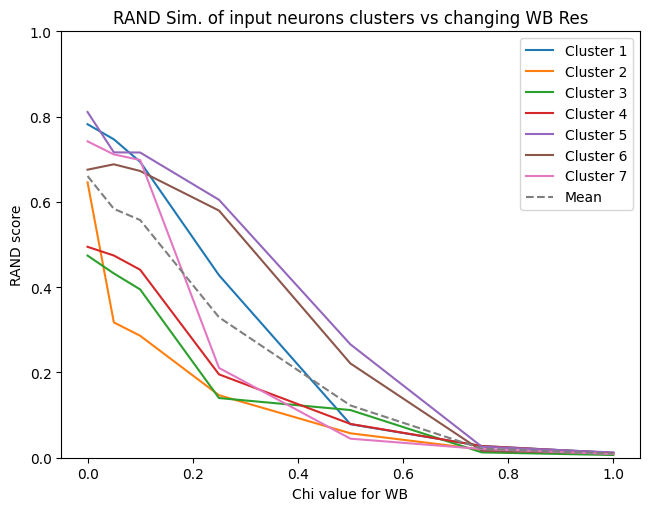

In [61]:
for i in range(1, 8):
    plt.plot([float(res) for res in resolutions],
             [cluster_rand_similarities[i][res] for res in resolutions],
             label = f'Cluster {i}')
plt.plot([float(res) for res in resolutions],
         [np.mean([cluster_rand_similarities[i][res] for i in range(1,8)]) for res in resolutions], label = 'Mean', linestyle = '--')
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.xlabel('Chi value for WB')
plt.ylabel('RAND score')
plt.title('RAND Sim. of input neurons clusters vs changing WB Res')
plt.show()

Note: By definition, in the clusterwise break-up, since the neurons are chosen such that they are all from the same cluster in run 1, the rand similarity and jaccard similarity are exactly the same